In [1]:
import numpy as np
import torch
## import torch.nn as nn
import torch.nn.functional as F
import gym
from collections import deque
import random
import matplotlib.pyplot as plt

import time
from TD3_Fork import TD3_FORK

env = gym.make('BipedalWalkerHardcore-v3')
agent = TD3_FORK(env, batch_size = 100)

threshold = env.spec.reward_threshold
max_steps = env._max_episode_steps
print(' threshold: ', threshold, ', max_steps: ', max_steps)

start_timestep=10000 # it was 0            #time_step to select action based on Actor


 threshold:  300 , max_steps:  2000


/home/rafaels/ml-agents/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
# save(agent = agent, filename='checkpnt, directory = 'dir_chkpoint')     
def save(agent, directory, filename, episode, reward):
    torch.save(agent.actor.state_dict(), '%s/%s_actor_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic.state_dict(), '%s/%s_critic_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.sysmodel.state_dict(), '%s/%s_sysmodel_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.actor_target.state_dict(), '%s/%s_actor_target_%s_%s.pth' % (directory, filename, episode, reward))
    torch.save(agent.critic_target.state_dict(), '%s/%s_critic_target_%s_%s.pth' % (directory, filename, episode, reward))
    

In [3]:
def td3_fork_train(total_episodes=40000):
    
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = [] 
    num_steps_deque = deque(maxlen=100)
    avg_numm_steps_array = []
    
    total_timesteps = 0
    sys_loss = 0
    expcount = 0
    totrain = 0
    falling_down = 0

    time_start = time.time()                   # Init start time
    
    for i_episode in range(total_episodes):
        state = env.reset()
        episode_reward = 0
        episode_steps = 0
        timestep = 0
        temp_replay_buffer = []

        for st in range(max_steps):

            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                ## std_noice is moved into agent.policy
                action = agent.policy(state)

            # Recieve state and reward from environment.
            next_state, reward, done, info = env.step(action)
            #change original reward from -100 to -5 and 5*reward for other values
            episode_reward += reward
            episode_steps += 1
            
            if reward == -100:
                add_reward = -1
                reward = -5
                falling_down += 1
                expcount += 1
            else:
                add_reward = 0
                reward = 5 * reward

            temp_replay_buffer.append((state, action, reward, add_reward, next_state, done))
            
            # End this episode when `done` is True
            if done:
                if add_reward == -1 or episode_reward < 250:            
                    totrain = 1
                    for temp in temp_replay_buffer: 
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                elif expcount > 0 and np.random.rand() > 0.5:
                    totrain = 1
                    expcount -= 10
                    for temp in temp_replay_buffer: 
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                break
            state = next_state
            timestep += 1     
            total_timesteps += 1
        
        scores_deque.append(episode_reward)
        scores_array.append(episode_reward)        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)
        
        num_steps_deque.append(episode_steps)
        avg_num_steps = np.mean(num_steps_deque)
        avg_numm_steps_array.append(avg_num_steps)


        #Training agent only when new experiences are added to the replay buffer
        weight =  1 - np.clip(avg_score/300, 0, 1)
        if totrain == 1:
            sys_loss = agent.learn_and_update_weights_by_replay(timestep, weight, totrain)
        else: 
            sys_loss = agent.learn_and_update_weights_by_replay(100, weight, totrain)
        totrain = 0

        if i_episode % 200 == 0 and i_episode > 0:
            reward_round = round(episode_reward, 2)
            save(agent, 'dir_bpw_td3_fork_upd', 'weights', str(i_episode), str(reward_round))
        
        if i_episode % 10 == 0 and i_episode > 0:  

            s = (int)(time.time() - time_start)
            min_score = np.min(scores_deque)
            max_score = np.max(scores_deque)
            med_score = np.median(scores_deque)
            print("Ep.: {}, Avg.Num.St.: {:.1f}, Min-Max.Sc.: ({:.2f}, {:.2f}), Med.Sc.:{:.3f}, Avg.Sc.: {:.3f}, Time: {:02}:{:02}:{:02}, F.D.: {}, weight: {:.3f}".\
                format(i_episode, avg_num_steps, min_score, max_score, med_score, avg_score, \
                  s//3600, s%3600//60, s%60, falling_down, weight ))
            
        if (avg_score >= threshold):            
            print('Solved environment with Avg Score:  ', avg_score)
            print('total_timesteps: ', total_timesteps)
            break;
            

    return scores_array, avg_scores_array, avg_numm_steps_array 

scores, avg_scores, avg_numm_steps = td3_fork_train()


Ep.: 10, Avg.Num.St.: 344.0, Min-Max.Sc.: (-145.25, -100.11), Med.Sc.:-108.573, Avg.Sc.: -111.856, Time: 00:00:02, F.D.: 10, weight: 1.000
Ep.: 20, Avg.Num.St.: 670.0, Min-Max.Sc.: (-145.25, -36.62), Med.Sc.:-103.688, Avg.Sc.: -105.927, Time: 00:01:37, F.D.: 15, weight: 1.000
Ep.: 30, Avg.Num.St.: 535.4, Min-Max.Sc.: (-184.94, -36.62), Med.Sc.:-102.834, Avg.Sc.: -107.282, Time: 00:02:42, F.D.: 24, weight: 1.000
Ep.: 40, Avg.Num.St.: 419.7, Min-Max.Sc.: (-184.94, -36.62), Med.Sc.:-102.257, Avg.Sc.: -105.725, Time: 00:02:58, F.D.: 34, weight: 1.000
Ep.: 50, Avg.Num.St.: 353.6, Min-Max.Sc.: (-184.94, -36.62), Med.Sc.:-101.545, Avg.Sc.: -104.010, Time: 00:03:20, F.D.: 44, weight: 1.000
Ep.: 60, Avg.Num.St.: 343.0, Min-Max.Sc.: (-184.94, -36.62), Med.Sc.:-100.957, Avg.Sc.: -102.427, Time: 00:04:36, F.D.: 53, weight: 1.000
Ep.: 70, Avg.Num.St.: 336.5, Min-Max.Sc.: (-184.94, -36.62), Med.Sc.:-100.833, Avg.Sc.: -101.510, Time: 00:05:54, F.D.: 62, weight: 1.000
Ep.: 80, Avg.Num.St.: 317.3, Min-

Ep.: 610, Avg.Num.St.: 393.3, Min-Max.Sc.: (-150.22, 290.12), Med.Sc.:-52.439, Avg.Sc.: -36.410, Time: 01:23:10, F.D.: 588, weight: 1.000
Ep.: 620, Avg.Num.St.: 385.5, Min-Max.Sc.: (-150.22, 290.12), Med.Sc.:-54.257, Avg.Sc.: -37.439, Time: 01:24:53, F.D.: 598, weight: 1.000
Ep.: 630, Avg.Num.St.: 401.9, Min-Max.Sc.: (-150.22, 291.46), Med.Sc.:-52.439, Avg.Sc.: -32.457, Time: 01:26:35, F.D.: 607, weight: 1.000
Ep.: 640, Avg.Num.St.: 423.3, Min-Max.Sc.: (-150.22, 291.46), Med.Sc.:-47.143, Avg.Sc.: -28.773, Time: 01:29:13, F.D.: 617, weight: 1.000
Ep.: 650, Avg.Num.St.: 403.9, Min-Max.Sc.: (-150.22, 291.46), Med.Sc.:-50.014, Avg.Sc.: -32.345, Time: 01:31:02, F.D.: 627, weight: 1.000
Ep.: 660, Avg.Num.St.: 373.4, Min-Max.Sc.: (-114.58, 291.46), Med.Sc.:-51.452, Avg.Sc.: -34.984, Time: 01:31:48, F.D.: 637, weight: 1.000
Ep.: 670, Avg.Num.St.: 370.7, Min-Max.Sc.: (-114.58, 291.46), Med.Sc.:-50.553, Avg.Sc.: -36.181, Time: 01:34:05, F.D.: 647, weight: 1.000
Ep.: 680, Avg.Num.St.: 376.4, Min-

Ep.: 1210, Avg.Num.St.: 564.0, Min-Max.Sc.: (-93.91, 303.78), Med.Sc.:-1.926, Avg.Sc.: 36.981, Time: 03:59:39, F.D.: 1159, weight: 0.877
Ep.: 1220, Avg.Num.St.: 588.9, Min-Max.Sc.: (-93.91, 303.78), Med.Sc.:-1.926, Avg.Sc.: 42.758, Time: 04:04:03, F.D.: 1168, weight: 0.857
Ep.: 1230, Avg.Num.St.: 623.3, Min-Max.Sc.: (-93.91, 303.78), Med.Sc.:5.033, Avg.Sc.: 48.583, Time: 04:09:18, F.D.: 1177, weight: 0.838
Ep.: 1240, Avg.Num.St.: 653.6, Min-Max.Sc.: (-93.91, 303.78), Med.Sc.:6.205, Avg.Sc.: 56.378, Time: 04:13:38, F.D.: 1184, weight: 0.812
Ep.: 1250, Avg.Num.St.: 689.9, Min-Max.Sc.: (-85.39, 303.78), Med.Sc.:19.089, Avg.Sc.: 68.326, Time: 04:17:26, F.D.: 1189, weight: 0.772
Ep.: 1260, Avg.Num.St.: 749.2, Min-Max.Sc.: (-85.39, 303.78), Med.Sc.:51.892, Avg.Sc.: 84.350, Time: 04:24:17, F.D.: 1195, weight: 0.719
Ep.: 1270, Avg.Num.St.: 754.6, Min-Max.Sc.: (-86.85, 303.78), Med.Sc.:51.892, Avg.Sc.: 86.025, Time: 04:27:14, F.D.: 1203, weight: 0.713
Ep.: 1280, Avg.Num.St.: 793.5, Min-Max.Sc.:

Ep.: 1810, Avg.Num.St.: 911.9, Min-Max.Sc.: (-92.38, 305.79), Med.Sc.:292.917, Avg.Sc.: 182.278, Time: 08:11:00, F.D.: 1509, weight: 0.392
Ep.: 1820, Avg.Num.St.: 903.0, Min-Max.Sc.: (-92.38, 305.79), Med.Sc.:291.418, Avg.Sc.: 177.179, Time: 08:16:58, F.D.: 1515, weight: 0.409
Ep.: 1830, Avg.Num.St.: 893.7, Min-Max.Sc.: (-92.38, 305.79), Med.Sc.:292.789, Avg.Sc.: 176.453, Time: 08:20:22, F.D.: 1521, weight: 0.412
Ep.: 1840, Avg.Num.St.: 874.2, Min-Max.Sc.: (-92.38, 305.79), Med.Sc.:243.938, Avg.Sc.: 169.547, Time: 08:23:47, F.D.: 1528, weight: 0.435
Ep.: 1850, Avg.Num.St.: 904.7, Min-Max.Sc.: (-80.22, 304.67), Med.Sc.:292.891, Avg.Sc.: 181.341, Time: 08:29:16, F.D.: 1532, weight: 0.396
Ep.: 1860, Avg.Num.St.: 879.4, Min-Max.Sc.: (-80.22, 304.67), Med.Sc.:292.789, Avg.Sc.: 174.128, Time: 08:33:35, F.D.: 1538, weight: 0.420
Ep.: 1870, Avg.Num.St.: 870.6, Min-Max.Sc.: (-80.22, 304.67), Med.Sc.:243.938, Avg.Sc.: 169.908, Time: 08:37:52, F.D.: 1544, weight: 0.434
Ep.: 1880, Avg.Num.St.: 866

Ep.: 2400, Avg.Num.St.: 940.9, Min-Max.Sc.: (-77.65, 305.12), Med.Sc.:296.454, Avg.Sc.: 198.849, Time: 10:44:02, F.D.: 1745, weight: 0.337
Ep.: 2410, Avg.Num.St.: 933.0, Min-Max.Sc.: (-77.65, 306.13), Med.Sc.:297.950, Avg.Sc.: 201.469, Time: 10:44:48, F.D.: 1746, weight: 0.328
Ep.: 2420, Avg.Num.St.: 912.7, Min-Max.Sc.: (-77.65, 306.13), Med.Sc.:297.007, Avg.Sc.: 196.405, Time: 10:46:23, F.D.: 1750, weight: 0.345
Ep.: 2430, Avg.Num.St.: 905.0, Min-Max.Sc.: (-77.65, 306.13), Med.Sc.:297.776, Avg.Sc.: 194.054, Time: 10:49:10, F.D.: 1753, weight: 0.353
Ep.: 2440, Avg.Num.St.: 884.9, Min-Max.Sc.: (-77.65, 306.13), Med.Sc.:295.882, Avg.Sc.: 186.249, Time: 10:50:53, F.D.: 1757, weight: 0.379
Ep.: 2450, Avg.Num.St.: 883.5, Min-Max.Sc.: (-77.65, 306.87), Med.Sc.:296.684, Avg.Sc.: 190.116, Time: 10:51:50, F.D.: 1759, weight: 0.366
Ep.: 2460, Avg.Num.St.: 862.9, Min-Max.Sc.: (-77.65, 306.87), Med.Sc.:295.730, Avg.Sc.: 181.091, Time: 10:55:14, F.D.: 1766, weight: 0.396
Ep.: 2470, Avg.Num.St.: 888

Ep.: 2990, Avg.Num.St.: 1025.0, Min-Max.Sc.: (-38.21, 306.84), Med.Sc.:300.045, Avg.Sc.: 249.923, Time: 12:43:59, F.D.: 1921, weight: 0.167
Ep.: 3000, Avg.Num.St.: 1039.5, Min-Max.Sc.: (-38.21, 306.84), Med.Sc.:300.045, Avg.Sc.: 254.590, Time: 12:45:23, F.D.: 1922, weight: 0.151
Ep.: 3010, Avg.Num.St.: 1036.5, Min-Max.Sc.: (-37.85, 306.84), Med.Sc.:299.956, Avg.Sc.: 249.903, Time: 12:48:31, F.D.: 1927, weight: 0.167
Ep.: 3020, Avg.Num.St.: 1033.8, Min-Max.Sc.: (-37.85, 306.84), Med.Sc.:299.417, Avg.Sc.: 249.761, Time: 12:49:39, F.D.: 1929, weight: 0.167
Ep.: 3030, Avg.Num.St.: 1028.1, Min-Max.Sc.: (-45.19, 306.84), Med.Sc.:299.322, Avg.Sc.: 248.228, Time: 12:51:46, F.D.: 1932, weight: 0.173
Ep.: 3040, Avg.Num.St.: 1026.2, Min-Max.Sc.: (-45.19, 306.84), Med.Sc.:299.417, Avg.Sc.: 247.539, Time: 12:53:24, F.D.: 1934, weight: 0.175
Ep.: 3050, Avg.Num.St.: 1041.1, Min-Max.Sc.: (-45.19, 305.51), Med.Sc.:299.564, Avg.Sc.: 252.175, Time: 12:54:42, F.D.: 1935, weight: 0.159
Ep.: 3060, Avg.Num.S

Ep.: 3580, Avg.Num.St.: 1001.7, Min-Max.Sc.: (-70.30, 306.67), Med.Sc.:298.994, Avg.Sc.: 237.898, Time: 14:18:47, F.D.: 2041, weight: 0.207
Ep.: 3590, Avg.Num.St.: 1020.3, Min-Max.Sc.: (-70.30, 306.67), Med.Sc.:299.437, Avg.Sc.: 246.687, Time: 14:19:41, F.D.: 2042, weight: 0.178
Ep.: 3600, Avg.Num.St.: 1020.9, Min-Max.Sc.: (-70.30, 306.67), Med.Sc.:299.437, Avg.Sc.: 246.696, Time: 14:21:49, F.D.: 2045, weight: 0.178
Ep.: 3610, Avg.Num.St.: 1015.5, Min-Max.Sc.: (-70.30, 306.67), Med.Sc.:299.560, Avg.Sc.: 246.999, Time: 14:23:05, F.D.: 2047, weight: 0.177
Ep.: 3620, Avg.Num.St.: 1018.6, Min-Max.Sc.: (-70.30, 306.67), Med.Sc.:299.862, Avg.Sc.: 247.618, Time: 14:26:07, F.D.: 2051, weight: 0.175
Ep.: 3630, Avg.Num.St.: 1013.6, Min-Max.Sc.: (-75.07, 306.05), Med.Sc.:299.875, Avg.Sc.: 246.800, Time: 14:27:46, F.D.: 2054, weight: 0.177
Ep.: 3640, Avg.Num.St.: 1008.5, Min-Max.Sc.: (-75.07, 306.05), Med.Sc.:299.875, Avg.Sc.: 245.909, Time: 14:28:30, F.D.: 2055, weight: 0.180
Ep.: 3650, Avg.Num.S

Ep.: 4170, Avg.Num.St.: 1042.1, Min-Max.Sc.: (-71.07, 305.86), Med.Sc.:299.721, Avg.Sc.: 259.551, Time: 15:59:54, F.D.: 2166, weight: 0.135
Ep.: 4180, Avg.Num.St.: 1045.2, Min-Max.Sc.: (-71.07, 305.86), Med.Sc.:299.571, Avg.Sc.: 260.358, Time: 16:01:13, F.D.: 2167, weight: 0.132
Ep.: 4190, Avg.Num.St.: 1041.8, Min-Max.Sc.: (-71.07, 305.86), Med.Sc.:299.372, Avg.Sc.: 256.563, Time: 16:02:59, F.D.: 2169, weight: 0.145
Ep.: 4200, Avg.Num.St.: 1058.5, Min-Max.Sc.: (-71.07, 305.86), Med.Sc.:299.426, Avg.Sc.: 262.456, Time: 16:03:39, F.D.: 2169, weight: 0.125
Ep.: 4210, Avg.Num.St.: 1062.0, Min-Max.Sc.: (-71.07, 305.54), Med.Sc.:299.987, Avg.Sc.: 264.537, Time: 16:05:10, F.D.: 2171, weight: 0.118
Ep.: 4220, Avg.Num.St.: 1058.8, Min-Max.Sc.: (-74.42, 305.54), Med.Sc.:300.385, Avg.Sc.: 265.053, Time: 16:07:13, F.D.: 2173, weight: 0.116
Ep.: 4230, Avg.Num.St.: 1073.5, Min-Max.Sc.: (-74.42, 305.69), Med.Sc.:300.713, Avg.Sc.: 274.454, Time: 16:07:53, F.D.: 2173, weight: 0.085
Ep.: 4240, Avg.Num.S

Ep.: 4760, Avg.Num.St.: 1014.5, Min-Max.Sc.: (-56.11, 307.88), Med.Sc.:299.119, Avg.Sc.: 255.001, Time: 17:17:53, F.D.: 2249, weight: 0.150
Ep.: 4770, Avg.Num.St.: 1003.0, Min-Max.Sc.: (-56.11, 307.88), Med.Sc.:298.812, Avg.Sc.: 247.953, Time: 17:19:35, F.D.: 2251, weight: 0.173
Ep.: 4780, Avg.Num.St.: 1022.5, Min-Max.Sc.: (-41.96, 307.88), Med.Sc.:299.162, Avg.Sc.: 258.776, Time: 17:20:14, F.D.: 2251, weight: 0.137
Ep.: 4790, Avg.Num.St.: 1027.8, Min-Max.Sc.: (-41.96, 307.88), Med.Sc.:299.696, Avg.Sc.: 263.377, Time: 17:21:20, F.D.: 2252, weight: 0.122
Ep.: 4800, Avg.Num.St.: 1019.3, Min-Max.Sc.: (-41.96, 307.88), Med.Sc.:299.162, Avg.Sc.: 258.388, Time: 17:23:20, F.D.: 2256, weight: 0.139
Ep.: 4810, Avg.Num.St.: 1026.9, Min-Max.Sc.: (-41.96, 306.11), Med.Sc.:299.320, Avg.Sc.: 262.183, Time: 17:23:59, F.D.: 2256, weight: 0.126
Ep.: 4820, Avg.Num.St.: 1022.1, Min-Max.Sc.: (-41.96, 306.11), Med.Sc.:300.141, Avg.Sc.: 261.013, Time: 17:25:39, F.D.: 2258, weight: 0.130
Ep.: 4830, Avg.Num.S

Ep.: 5350, Avg.Num.St.: 1031.2, Min-Max.Sc.: (-78.16, 309.59), Med.Sc.:300.994, Avg.Sc.: 264.825, Time: 18:39:28, F.D.: 2336, weight: 0.117
Ep.: 5360, Avg.Num.St.: 1020.6, Min-Max.Sc.: (-78.16, 309.59), Med.Sc.:301.125, Avg.Sc.: 261.119, Time: 18:40:47, F.D.: 2339, weight: 0.130
Ep.: 5370, Avg.Num.St.: 1032.4, Min-Max.Sc.: (-78.16, 309.59), Med.Sc.:301.540, Avg.Sc.: 267.910, Time: 18:42:01, F.D.: 2340, weight: 0.107
Ep.: 5380, Avg.Num.St.: 1041.5, Min-Max.Sc.: (-10.89, 309.59), Med.Sc.:301.982, Avg.Sc.: 275.290, Time: 18:43:50, F.D.: 2341, weight: 0.082
Ep.: 5390, Avg.Num.St.: 1015.5, Min-Max.Sc.: (-43.79, 309.59), Med.Sc.:301.723, Avg.Sc.: 265.093, Time: 18:44:53, F.D.: 2344, weight: 0.116
Ep.: 5400, Avg.Num.St.: 1010.2, Min-Max.Sc.: (-43.79, 309.59), Med.Sc.:301.579, Avg.Sc.: 262.614, Time: 18:45:57, F.D.: 2345, weight: 0.125
Ep.: 5410, Avg.Num.St.: 1020.0, Min-Max.Sc.: (-43.79, 309.59), Med.Sc.:301.309, Avg.Sc.: 266.498, Time: 18:46:38, F.D.: 2345, weight: 0.112
Ep.: 5420, Avg.Num.S

Ep.: 5940, Avg.Num.St.: 1034.1, Min-Max.Sc.: (-53.10, 307.06), Med.Sc.:301.809, Avg.Sc.: 270.157, Time: 19:56:11, F.D.: 2419, weight: 0.099
Ep.: 5950, Avg.Num.St.: 1036.0, Min-Max.Sc.: (-53.10, 307.06), Med.Sc.:301.801, Avg.Sc.: 271.480, Time: 19:56:51, F.D.: 2419, weight: 0.095
Ep.: 5960, Avg.Num.St.: 1044.0, Min-Max.Sc.: (-16.15, 307.06), Med.Sc.:301.754, Avg.Sc.: 275.254, Time: 19:58:10, F.D.: 2421, weight: 0.082
Ep.: 5970, Avg.Num.St.: 1040.5, Min-Max.Sc.: (-16.15, 307.06), Med.Sc.:301.809, Avg.Sc.: 272.942, Time: 20:01:19, F.D.: 2425, weight: 0.090
Ep.: 5980, Avg.Num.St.: 1033.1, Min-Max.Sc.: (-16.15, 307.06), Med.Sc.:301.754, Avg.Sc.: 270.923, Time: 20:02:39, F.D.: 2427, weight: 0.097
Ep.: 5990, Avg.Num.St.: 1027.4, Min-Max.Sc.: (-16.15, 307.06), Med.Sc.:301.663, Avg.Sc.: 267.341, Time: 20:04:23, F.D.: 2429, weight: 0.109
Ep.: 6000, Avg.Num.St.: 1026.1, Min-Max.Sc.: (-16.15, 307.09), Med.Sc.:301.602, Avg.Sc.: 267.440, Time: 20:05:04, F.D.: 2429, weight: 0.109
Ep.: 6010, Avg.Num.S

Ep.: 6530, Avg.Num.St.: 1040.9, Min-Max.Sc.: (4.02, 308.89), Med.Sc.:301.522, Avg.Sc.: 281.098, Time: 21:04:06, F.D.: 2482, weight: 0.063
Ep.: 6540, Avg.Num.St.: 1022.2, Min-Max.Sc.: (-30.25, 308.89), Med.Sc.:300.979, Avg.Sc.: 271.669, Time: 21:05:20, F.D.: 2485, weight: 0.094
Ep.: 6550, Avg.Num.St.: 1010.6, Min-Max.Sc.: (-30.25, 309.93), Med.Sc.:301.522, Avg.Sc.: 266.731, Time: 21:07:06, F.D.: 2488, weight: 0.111
Ep.: 6560, Avg.Num.St.: 1019.6, Min-Max.Sc.: (-30.25, 309.93), Med.Sc.:302.486, Avg.Sc.: 269.949, Time: 21:07:45, F.D.: 2488, weight: 0.100
Ep.: 6570, Avg.Num.St.: 1021.4, Min-Max.Sc.: (-30.25, 309.93), Med.Sc.:302.195, Avg.Sc.: 270.732, Time: 21:08:57, F.D.: 2489, weight: 0.098
Ep.: 6580, Avg.Num.St.: 1017.9, Min-Max.Sc.: (-76.97, 309.93), Med.Sc.:301.880, Avg.Sc.: 268.174, Time: 21:10:58, F.D.: 2491, weight: 0.106
Ep.: 6590, Avg.Num.St.: 1006.1, Min-Max.Sc.: (-76.97, 309.93), Med.Sc.:302.111, Avg.Sc.: 263.498, Time: 21:12:26, F.D.: 2493, weight: 0.122
Ep.: 6600, Avg.Num.St.

Ep.: 7120, Avg.Num.St.: 1067.9, Min-Max.Sc.: (-26.50, 313.63), Med.Sc.:301.625, Avg.Sc.: 293.024, Time: 22:08:02, F.D.: 2540, weight: 0.023
Ep.: 7130, Avg.Num.St.: 1080.9, Min-Max.Sc.: (-26.50, 307.13), Med.Sc.:301.094, Avg.Sc.: 294.929, Time: 22:08:43, F.D.: 2540, weight: 0.017
Ep.: 7140, Avg.Num.St.: 1082.1, Min-Max.Sc.: (-26.50, 307.13), Med.Sc.:301.146, Avg.Sc.: 293.743, Time: 22:10:52, F.D.: 2541, weight: 0.021
Ep.: 7150, Avg.Num.St.: 1070.7, Min-Max.Sc.: (-63.05, 311.47), Med.Sc.:301.563, Avg.Sc.: 289.210, Time: 22:12:13, F.D.: 2543, weight: 0.036
Ep.: 7160, Avg.Num.St.: 1056.1, Min-Max.Sc.: (-63.05, 311.47), Med.Sc.:301.252, Avg.Sc.: 282.307, Time: 22:14:01, F.D.: 2546, weight: 0.059
Ep.: 7170, Avg.Num.St.: 1056.1, Min-Max.Sc.: (-63.05, 311.47), Med.Sc.:301.597, Avg.Sc.: 282.567, Time: 22:14:41, F.D.: 2546, weight: 0.058
Ep.: 7180, Avg.Num.St.: 1056.1, Min-Max.Sc.: (-63.05, 311.47), Med.Sc.:301.597, Avg.Sc.: 283.113, Time: 22:15:36, F.D.: 2547, weight: 0.056
Ep.: 7190, Avg.Num.S

Ep.: 7710, Avg.Num.St.: 1028.5, Min-Max.Sc.: (-57.70, 311.81), Med.Sc.:304.253, Avg.Sc.: 288.385, Time: 23:12:06, F.D.: 2591, weight: 0.039
Ep.: 7720, Avg.Num.St.: 1031.0, Min-Max.Sc.: (-57.70, 311.81), Med.Sc.:303.901, Avg.Sc.: 287.726, Time: 23:12:47, F.D.: 2591, weight: 0.041
Ep.: 7730, Avg.Num.St.: 1034.8, Min-Max.Sc.: (-57.70, 311.81), Med.Sc.:303.334, Avg.Sc.: 289.295, Time: 23:13:28, F.D.: 2591, weight: 0.036
Ep.: 7740, Avg.Num.St.: 1042.2, Min-Max.Sc.: (-57.70, 311.81), Med.Sc.:302.446, Avg.Sc.: 291.103, Time: 23:14:08, F.D.: 2591, weight: 0.030
Ep.: 7750, Avg.Num.St.: 1056.4, Min-Max.Sc.: (-14.43, 311.81), Med.Sc.:301.828, Avg.Sc.: 296.696, Time: 23:14:48, F.D.: 2591, weight: 0.011
Ep.: 7760, Avg.Num.St.: 1065.8, Min-Max.Sc.: (-14.43, 311.81), Med.Sc.:301.459, Avg.Sc.: 298.762, Time: 23:15:29, F.D.: 2591, weight: 0.004
Ep.: 7770, Avg.Num.St.: 1062.5, Min-Max.Sc.: (-14.43, 311.81), Med.Sc.:301.144, Avg.Sc.: 295.583, Time: 23:16:23, F.D.: 2592, weight: 0.015
Ep.: 7780, Avg.Num.S

Ep.: 8300, Avg.Num.St.: 991.7, Min-Max.Sc.: (14.21, 308.60), Med.Sc.:302.464, Avg.Sc.: 270.224, Time: 24:06:46, F.D.: 2630, weight: 0.099
Ep.: 8310, Avg.Num.St.: 1000.9, Min-Max.Sc.: (16.70, 308.60), Med.Sc.:302.583, Avg.Sc.: 274.059, Time: 24:08:49, F.D.: 2631, weight: 0.086
Ep.: 8320, Avg.Num.St.: 1005.6, Min-Max.Sc.: (28.01, 308.79), Med.Sc.:303.157, Avg.Sc.: 277.190, Time: 24:09:29, F.D.: 2631, weight: 0.076
Ep.: 8330, Avg.Num.St.: 1007.1, Min-Max.Sc.: (28.01, 308.79), Med.Sc.:303.417, Avg.Sc.: 277.202, Time: 24:10:28, F.D.: 2632, weight: 0.076
Ep.: 8340, Avg.Num.St.: 1010.5, Min-Max.Sc.: (28.01, 308.79), Med.Sc.:303.904, Avg.Sc.: 277.495, Time: 24:11:07, F.D.: 2632, weight: 0.075
Ep.: 8350, Avg.Num.St.: 1017.1, Min-Max.Sc.: (28.01, 308.79), Med.Sc.:304.081, Avg.Sc.: 280.293, Time: 24:11:48, F.D.: 2632, weight: 0.066
Ep.: 8360, Avg.Num.St.: 1027.4, Min-Max.Sc.: (28.01, 308.79), Med.Sc.:303.904, Avg.Sc.: 282.959, Time: 24:13:09, F.D.: 2633, weight: 0.057
Ep.: 8370, Avg.Num.St.: 1051

In [4]:
reward_round = round(np.max(scores), 2)
save(agent, 'dir_bpw_td3_fork_upd', 'weights', 'final', str(reward_round))

length of scores:  8681 , len of avg_scores:  8681


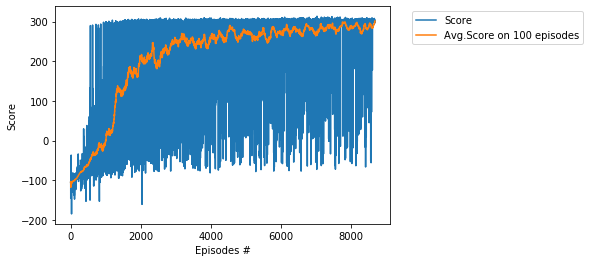

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg.Score on 100 episodes")
## plt.plot(np.arange(1, len(avg_numm_steps)+1), avg_numm_steps, label="Avg.Num.Steps on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()

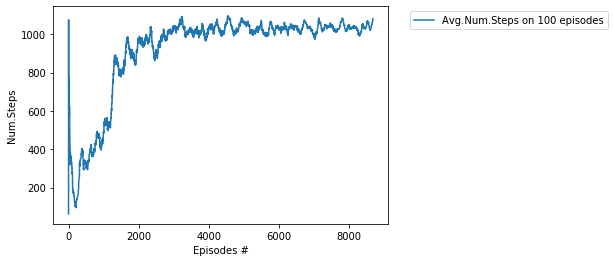

In [6]:
fig2 = plt.figure()
ax = fig2.add_subplot(111)
plt.plot(np.arange(1, len(avg_numm_steps)+1), avg_numm_steps, label="Avg.Num.Steps on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Num.Steps')
plt.xlabel('Episodes #')
plt.show()

In [ ]:
env.close()